# Introduction
**Problem Statement:** "In this competition, you must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans."
**Git Hub Repo Link:** https://github.com/brwi2400/CNN-Cancer-Detection-Kaggle-Mini-Project

In [2]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Exploratory Data Analysis
- View train_labels records.
- Plot distribution of labels
- View 5 Random plots

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


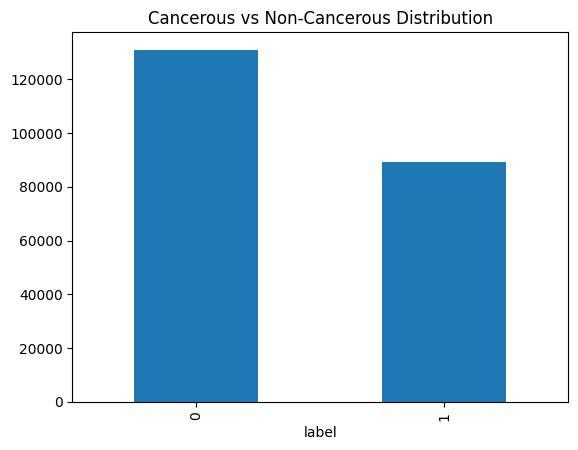

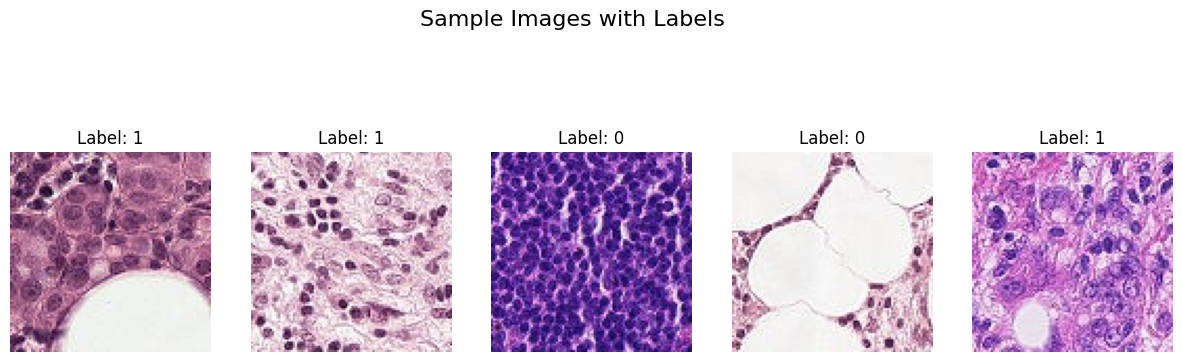

In [3]:
train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
print(train_labels.head())

train_labels['label'].value_counts().plot(kind='bar', title='Cancerous vs Non-Cancerous Distribution')
plt.show()


samples = train_labels.sample(n=5, random_state=45)
fig, axes = plt.subplots(1, len(samples), figsize=(15, 5))
fig.suptitle('Sample Images with Labels', fontsize=16)

for i, (idx, row) in enumerate(samples.iterrows()):
    img_path = f"/kaggle/input/histopathologic-cancer-detection/train/{row['id']}.tif"
    img = Image.open(img_path)
    
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {row['label']}")
    axes[i].axis('off')

plt.show()

# Preprocessing

In [4]:
IMG_SIZE = (96, 96)  
BATCH_SIZE = 32

train_labels.id = train_labels.id + '.tif'
train_df, val_df = train_test_split(train_labels, test_size=0.2, stratify=train_labels['label'], random_state=123)

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
path = '/kaggle/input/histopathologic-cancer-detection'

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    directory=path+'/train', 
    x_col='id', y_col='label',
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode='raw'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df, 
    directory=path+'/train', 
    x_col='id', y_col='label',
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode='raw'
)

Found 176020 validated image filenames.
Found 44005 validated image filenames.


# Model Architecture
- Input layer
- 2D convolution layer
- Max Pooling Layer
- 2D convolution layer
- Max Pooling Layer
- 2D convolution layer
- Max Pooling Layer
- Flatten layer
- Dense layer
- Dropout layer
- Output layer 

In [5]:
model = Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(32, (3, 3), activation='relu'),  
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

callback = EarlyStopping(monitor='val_loss', mode='min', patience=3)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callback
)

# Save model
model.save('cancer_classification_model_final.h5')

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730337320.629160     103 service.cc:145] XLA service 0x7b7050004fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730337320.629217     103 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730337320.629221     103 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   1/5501 ━━━━━━━━━━━━━━━━━━━━ 12:44:33 8s/step - accuracy: 0.3438 - loss: 0.7533

I0000 00:00:1730337325.456304     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1684s 305ms/step - accuracy: 0.7733 - loss: 0.4909 - val_accuracy: 0.8332 - val_loss: 0.3812
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 842s 153ms/step - accuracy: 0.8367 - loss: 0.3786 - val_accuracy: 0.7955 - val_loss: 0.4726
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 838s 152ms/step - accuracy: 0.8512 - loss: 0.3504 - val_accuracy: 0.8121 - val_loss: 0.4010
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 848s 154ms/step - accuracy: 0.8589 - loss: 0.3356 - val_accuracy: 0.8400 - val_loss: 0.3737
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 834s 151ms/step - accuracy: 0.8664 - loss: 0.3210 - val_accuracy: 0.8736 - val_loss: 0.3046
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 801s 145ms/step - accuracy: 0.8739 - loss: 0.3110 - val_accuracy: 0.8227 - val_loss: 0.4367
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 759s 138ms/step - accuracy: 0.8758 - loss: 0.3009 - val_accuracy: 0.8609 - val_loss: 0.3282
Epoch 8/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 703s 128ms/step - accuracy: 0.

# Evaluation
- Plot Accuracy 
- Plot Loss

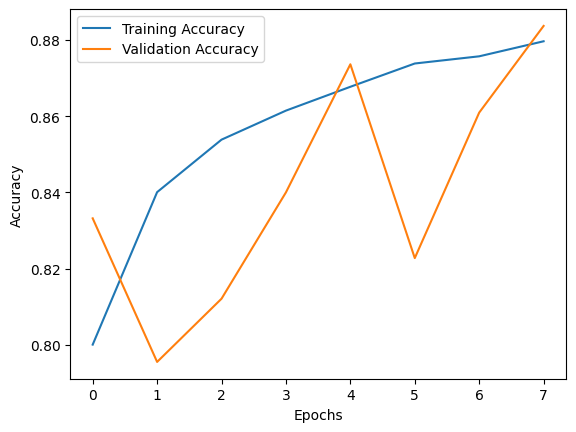

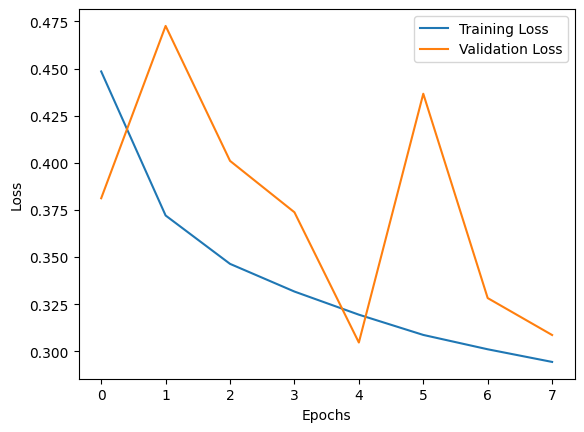

In [6]:
# Accuracy plot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Submission

In [7]:
test_image_folder = path +'/test'
test_image_files = os.listdir(test_image_folder)

test_df = pd.DataFrame({'id': test_image_files})

test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=str(test_image_folder),
    x_col='id',
    y_col=None,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)

predictions = model.predict(test_generator)
predictions = (predictions > 0.5).astype(int).flatten()

# Create submission 
submission = pd.DataFrame({'id': test_df['id'].str.split('.').str[0], 'label': predictions})
submission.to_csv('submission.csv', index=False)

Found 57458 validated image filenames.
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 309s 172ms/step


# Conclusion
After submitting my file I recieved a 50%.  I reviewed the labels and my model just guesses no for everything.  This is an aspect I would improve for next time.